In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This tutorial includes the implementation of the deep learning model, U-Net for multi-class semantic segmentation on CAMUS Dataset. The following are the steps involved in this process.
1. Import necessary libraries
2. Prepare data for processing
3. Create the model
4. Compile and train the model
5. Visualization of training loss and accuracy
6. Prediction of results using the model
7. Evaluation of performance of the model

## Step-1. Importing library packages

The packages imported here are TensorFlow dependencies, NumPyand Matplotlib. NumPy is the fundamental package used for working with arrays. Matplotlib is used here to read and display the images.

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow.keras as k
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model
# import tensorflow_addons as tfa

print(f"La version de Tensorflow es {tf.__version__}. Pueden Diferir algunas funciones!")

La version de Tensorflow es 2.17.0. Pueden Diferir algunas funciones!


## Step 2. Dataset preparation

https://www.kaggle.com/code/victortrigo/u-net-brian-mri-segmentation/data


In [ ]:
%%time
root = '/content/drive/MyDrive/train/New/'
def get_images_path():
    images = []
    labels = []


    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        print(d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters):
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels



def read_images(paths, tipefile):
    images = []

    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)

    else:

        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)

    imgs1 = np.array(images)


    return imgs1
#
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):

    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [ ]:
images, labels = get_images_path()
images = read_images(images , 'images')
masks = read_images(labels, 'masks')

  0%|          | 0/14 [00:00<?, ?it/s]

TCGA_CS_4941_19960909


  7%|▋         | 1/14 [00:00<00:03,  3.67it/s]

TCGA_CS_4942_19970222
TCGA_CS_4943_20000902
TCGA_CS_4944_20010208


 29%|██▊       | 4/14 [00:00<00:01,  6.87it/s]

TCGA_CS_5393_19990606


 36%|███▌      | 5/14 [00:00<00:01,  5.81it/s]

TCGA_CS_5395_19981004


 43%|████▎     | 6/14 [00:01<00:01,  5.17it/s]

TCGA_CS_5396_20010302


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


TCGA_CS_6186_20000601
TCGA_CS_6665_20010817
TCGA_CS_6666_20011109
TCGA_CS_6667_20011105
TCGA_HT_A5RC_19990831
TCGA_HT_A61A_20000127
TCGA_HT_A61B_19991127


100%|██████████| 364/364 [03:04<00:00,  1.98it/s]


In [ ]:
def plot_image(image, mask):
   plt.figure(figsize=(7, 7))

   plt.subplot(1, 2, 1)
   plt.imshow(image)
   plt.title('Image')
   plt.subplot(1, 2, 2)
   plt.imshow(mask)
   plt.title('Mask')

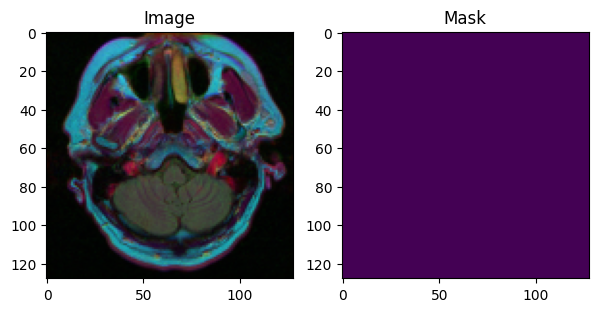

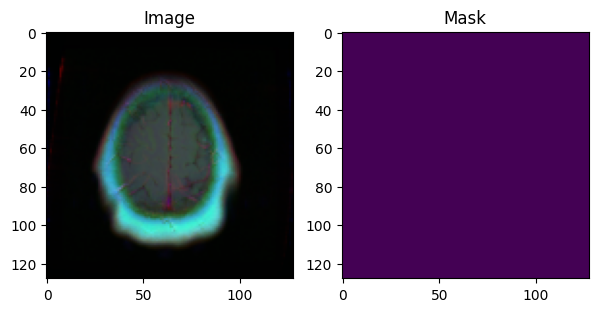

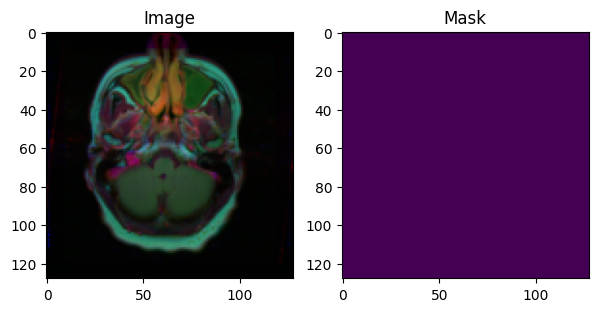

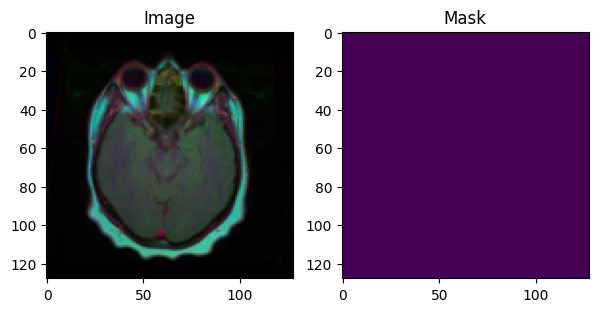

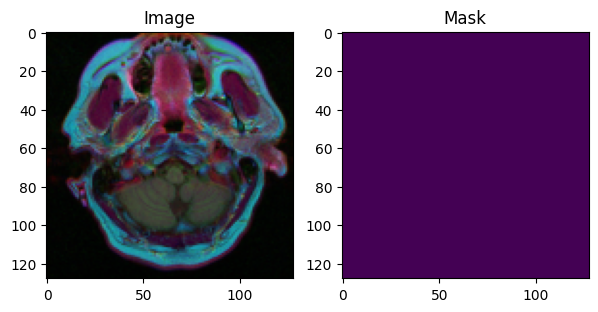

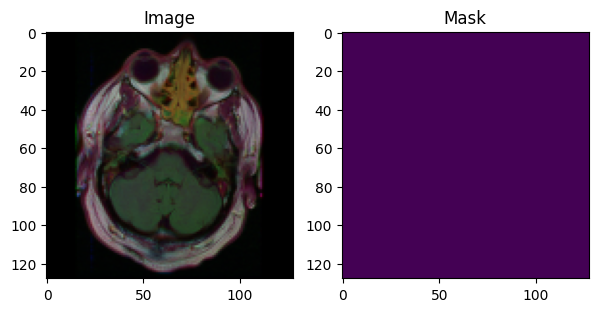

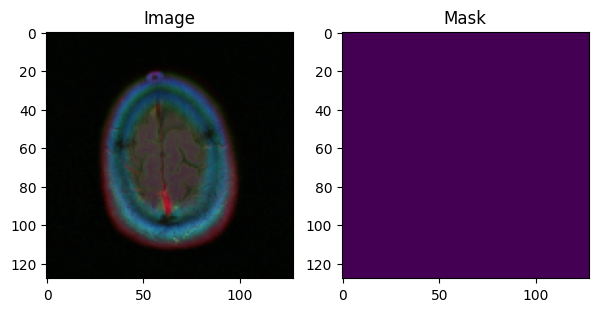

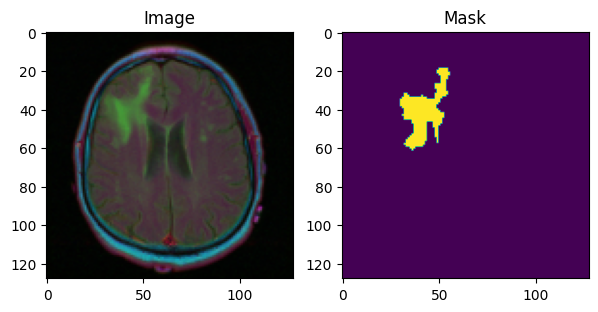

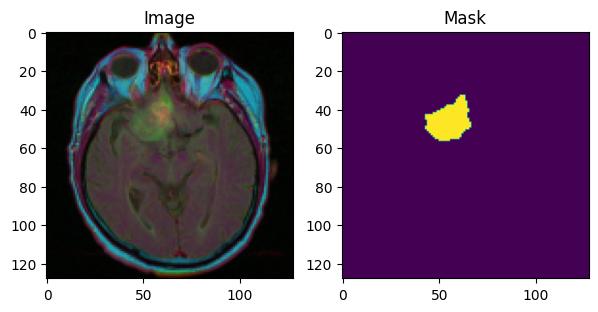

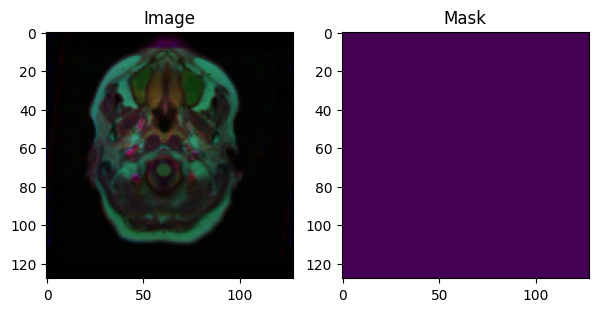

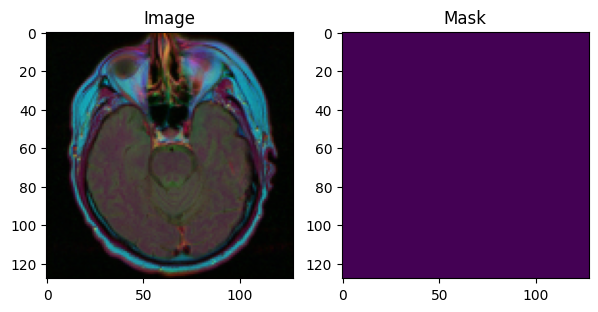

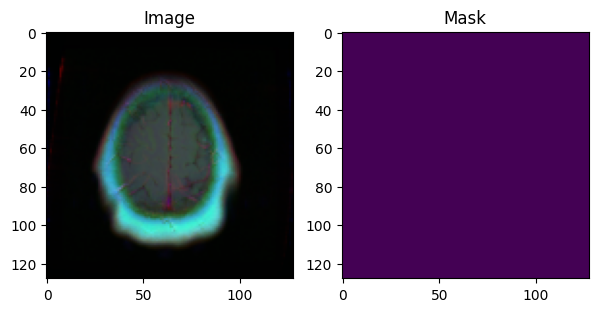

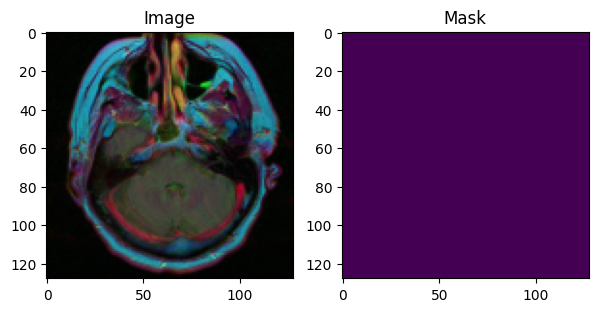

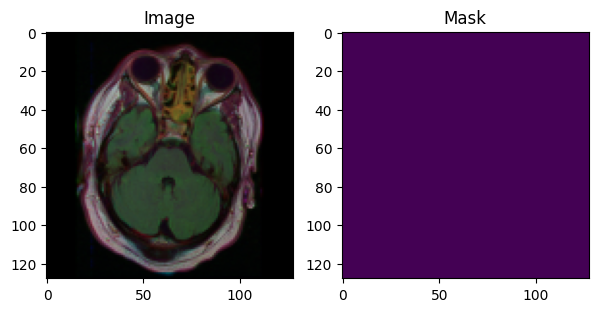

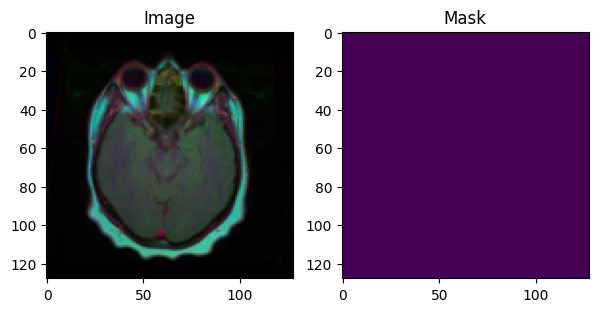

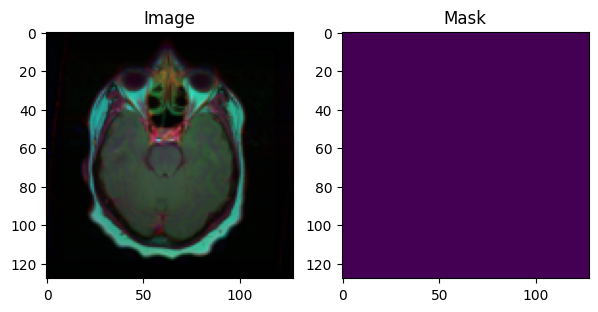

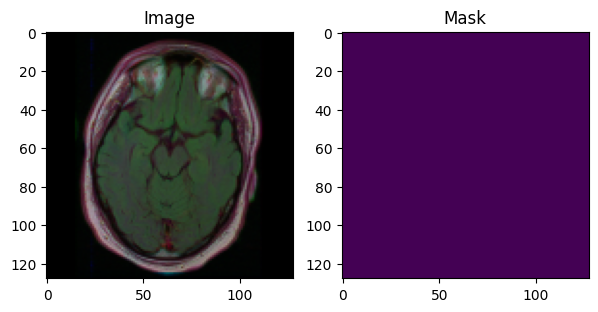

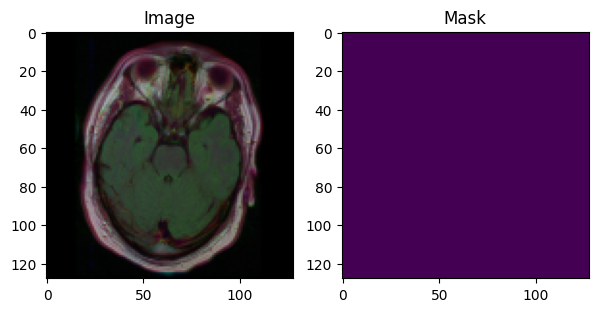

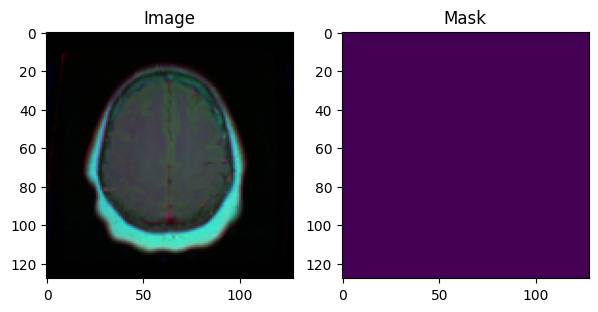

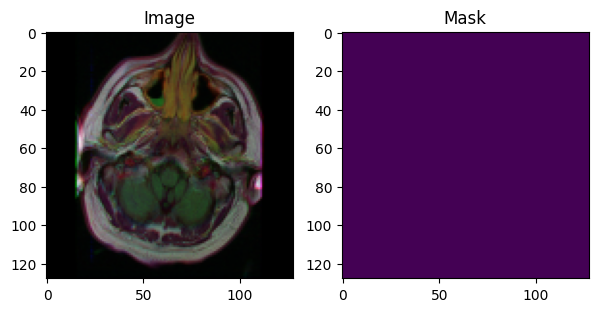

In [ ]:
l = [random.randint(0,50) for _ in range(20)]

for i in l:
    plot_image(images[i], masks[i])

In [ ]:
instance = []
for i in range(masks.shape[0]):

    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')

In [ ]:
count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Número de casos positivos: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Número de casos negativos: ', count)

Número de casos positivos:  141
Número de casos negativos:  223


In [ ]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])

images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Número de imágenes ',images_pos.shape)
print('Número de mascaras ',masks_pos.shape)


Número de imágenes  (141, 128, 128, 3)
Número de mascaras  (141, 128, 128, 1)


### Spliting training and Test Images

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .5, random_state = 32)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [ ]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (70, 128, 128, 3)
X_val shape:    (36, 128, 128, 3)
X_test shape:   (35, 128, 128, 3)


########## Masks ##########
y_train shape:  (70, 128, 128, 1)
y_val shape:    (36, 128, 128, 1)
y_test shape:   (35, 128, 128, 1)


## Step 3. Creating Model: VNet Model

##  Model 1: VNet Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def vnet_2d_modified(input_shape=(128, 128, 3), num_classes=1):
    """
    Improved V-Net implementation for 2D brain tumor segmentation.

    Parameters:
    input_shape: tuple, the shape of the input images (default: (128, 128, 3))
    num_classes: int, the number of classes in the output segmentation mask (default: 1)

    Returns:
    model: Keras Model instance
    """

    def conv_block(x, num_filters, kernel_size=3, padding='same', strides=1):
        x = layers.Conv2D(num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        x = layers.Dropout(0.3)(x)
        return x

    def down_block(x, num_filters):
        conv = conv_block(x, num_filters)
        conv = conv_block(conv, num_filters)
        pool = layers.MaxPooling2D((2, 2))(conv)
        return conv, pool

    def up_block(x, skip, num_filters):
        up = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(x)
        merge = layers.concatenate([up, skip])
        conv = conv_block(merge, num_filters)
        conv = conv_block(conv, num_filters)
        return conv

    def bottleneck(x, num_filters):
        conv = conv_block(x, num_filters)
        conv = conv_block(conv, num_filters)
        return conv

    inputs = layers.Input(input_shape)

    # Encoder
    skip1, pool1 = down_block(inputs, 32)
    skip2, pool2 = down_block(pool1, 64)
    skip3, pool3 = down_block(pool2, 128)
    skip4, pool4 = down_block(pool3, 256)

    # Bottleneck
    bottleneck_layer = bottleneck(pool4, 512)

    # Decoder
    up4 = up_block(bottleneck_layer, skip4, 256)
    up3 = up_block(up4, skip3, 128)
    up2 = up_block(up3, skip2, 64)
    up1 = up_block(up2, skip1, 32)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(up1)

    model = models.Model(inputs, outputs)
    return model

# Define Dice Loss function
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

vnet_model = vnet_2d_modified(input_shape=(128, 128, 3), num_classes=1)

# Compile the model with Dice Loss
vnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=dice_loss,
                   metrics=['accuracy'])

# Display the model summary
vnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Model-2: VNet

## Step 4. Compiling and Training  model

### 4.1. Compiling model: Model parameter setting and selection of loss function

The optimizer used here is Adam with a learning rate of 0.001 and the loss function is 'categorical crossentropy'

In [ ]:
# model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

###  4.2. Training of model:

The model  will be trained for 10 epochs with a batch size 4. The best weight, with maximum validation accuracy is saving as h5 file. Early stopping is included such that if the validation accuracy is not increasing for consecutive 8 epochs (patience=8), then the training will be stopped. ReduceLROnPlateau is used for optimizing the learning rate by monitoring the validation accuracy. If the validation accuracy is not increasing for consecutive 5 epochs, then the learning rate will reduce to half of current learning rate.

In [ ]:
history_1 = vnet_model.fit(X_train,
                          y_train,
                          verbose = 1,
                          epochs = 50,
                          validation_data = (X_val, y_val))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 71s 16s/step - accuracy: 0.4941 - loss: 0.9474 - val_accuracy: 0.3532 - val_loss: 0.9399
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 74s 14s/step - accuracy: 0.5995 - loss: 0.9097 - val_accuracy: 0.5219 - val_loss: 0.9355
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 16s/step - accuracy: 0.5919 - loss: 0.8882 - val_accuracy: 0.0636 - val_loss: 0.9335
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - accuracy: 0.6168 - loss: 0.8805 - val_accuracy: 0.0312 - val_loss: 0.9370
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.7359 - loss: 0.8761 - val_accuracy: 0.0312 - val_loss: 0.9393
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 14s/step - accuracy: 0.7345 - loss: 0.8577 - val_accuracy: 0.0312 - val_loss: 0.9395
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 14s/step - accuracy: 0.7450 - loss: 0.8633 - val_accuracy: 0.0312 - val_loss: 0.9396
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 15s/step - accuracy: 0.7893 - loss: 0.8497 - val_accuracy: 0.0436 - val_loss: 0.9390


In [ ]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
#                                                   factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
#                                                  min_delta = 0.0001)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=8, verbose=1,
#                                               mode = 'max', restore_best_weights = True)
# check_path = 'H:/CAMUS Dataset/unet.h5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


# history_1 = model.fit(data_train, mask_train, validation_data=(data_test,mask_test), epochs=10,
#                       batch_size=4, callbacks = [reduce_lr, early_stop, checkpoint] )

## Step 5. Visualization of training loss and accuracy

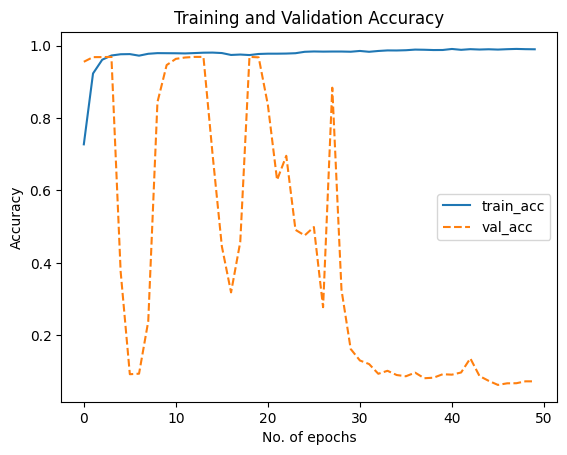

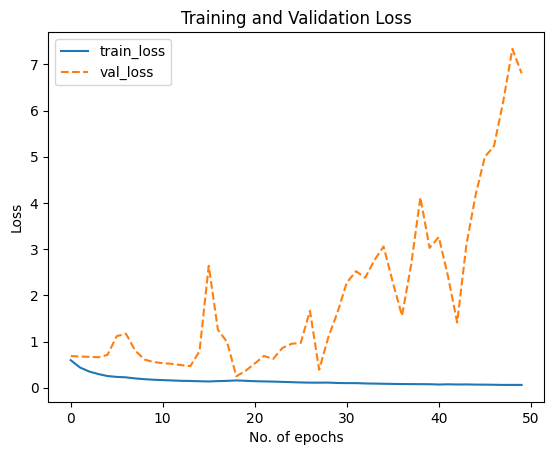

In [ ]:
plt.plot(history_1.history['accuracy'] , label = 'train_acc')
plt.plot(history_1.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history_1.history['loss'] , label = 'train_loss')
plt.plot(history_1.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()